In [4]:
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import cm
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.linalg as la
import scipy.integrate as sciint
from itertools import product
from functools import partial

import os

# Mine
from wilson_cowan_2d.simulations import concrete_wc_kernel as wck
from wilson_cowan_2d.simulations import wc_params as wcp
from wilson_cowan_2d.simulations.nonlinear_functions import decreasing_exponential, ssn_power_law
from wilson_cowan_2d.analysis import nulclines as nuc
from wilson_cowan_2d.analysis import stability as sta
from wilson_cowan_2d.utils import make_counter

# Jupyter Specific
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


# Data path
data_path = "../data/"
analysis_fldr = "SSN_Stability_Analysis"
data_save_path = os.path.join(data_path, analysis_fldr)
if not os.path.exists(data_save_path):
    os.makedirs(data_save_path)


from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

### Fixed Point Analysis

In [5]:
# Data path
import os

data_p = "data"
analysis_fldr = "SSN_2D_Simulations"
data_save_path = os.path.join(data_p, analysis_fldr)
if not os.path.exists(data_save_path):
    os.makedirs(data_save_path)

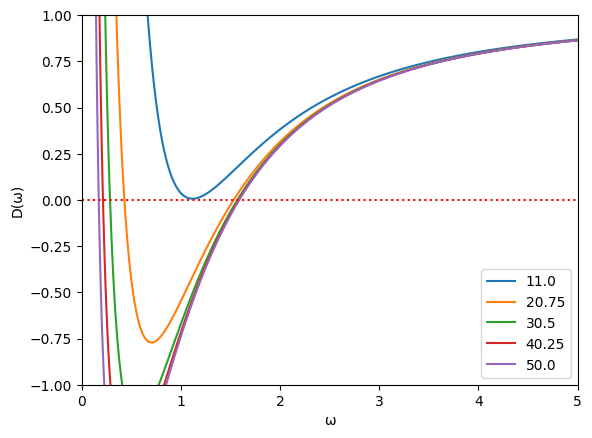

In [12]:
fig = plt.figure()
ax = plt.gca()

n = 3
k = 1

τe = 1
τi = 0.1 * τe
σe = 1
σi = 1 * σe


u_bar, v_bar = np.array([0.686, 5.14])
param = wcp.SSNDefaultParams(τ = np.array([τe, τi]), n=n, k=k,
                             size = 1, σ = np.array([σe, σi]))

rang = np.linspace(0,100, 10_000)
dw_test = sta.calc_Dω_range(param, (u_bar, v_bar),
                            1, np.linspace(11,50,5),
                            point_range=rang, derv=sta.derv_SSNF)

_ = [plt.plot(rang, dw[0], label=dw[1]) for dw in dw_test]
_ = plt.legend()
_ = plt.xlim(0, 5)
_ = plt.ylim(-1, 1)
_ = plt.hlines(0,0,1_000, color='r', linestyle=":")
_ = plt.ylabel("D(ω)")
_ = plt.xlabel("ω")

plt.savefig(os.path.join(data_save_path, "linear_stability_analysis.png"))

In [11]:
print(os.path.join(data_save_path))

data/SSN_2D_Simulations


In [ ]:
b  =sta.calc_bs(param, np.array(0.686), np.array(5.14), derv=sta.derv_SSNF)

In [735]:
(1 + b[1,1])/(b[0,0] - 1)

3.9033509235189725

### Periodic Oribit Analysis

In [132]:
period = 0.8

In [133]:
# To hold the time constant outputs
τ_output = list()
τ_err_list = list()

n = 3
k = 1

for ix, τ in enumerate(np.arange(3, 16, 0.1)):
    past_period = period
    τe = 1
    param = wcp.SSNDefaultParams(τ = np.array([τe, τe*τ]).reshape(2,1)
                                 , size = 1, n=n, k=k)

    inp = np.array([0.6865, 5.148322])  # .reshape(2,1)

    # Find a point in the periodic orbid
    test = wck.WCUnif(inp, param)
    end = 100
    ures = test((0, end), t_eval=np.arange(0, end, 0.1)) 
    uv_init = ures._solved.y.T[-1].reshape(2,1)

    # Find Period
    def find_period_func(T):
        start = wck.WCUnif(uv_init, param)
        res = start((0,T),simple=True, t_eval=(0,T))
        return la.norm(uv_init - res.y.T[-1].reshape(2,1)) # , res

    period = opt.fsolve(find_period_func, past_period)[0]
    i = 1
    while(i < 100 and (period < 0.001 or period > (past_period + 0.5))):
        retry = past_period + 0.01*i
        period = opt.fsolve(find_period_func, retry)[0]
        i+=1
    if i >= 100:
        print(f"{τ} didn't resolve. Final period: {period}")
        τ_err_list.append(τ)
        continue
        

    test = wck.WCUnif(uv_init, param)
    new_res = test((0,period), simple=True)

    new_u, new_v = new_res.y
    τ_output.append((τ, period, uv_init, (new_u, new_v)))
    
    if ix % 10 == 0:
        clear_output(wait=True)
        print("On iter: ", ix, "τ: ", τ, "Period: ", period)
    # _=  plt.plot(new_u, new_v)

On iter:  120 τ:  15.00000000000001 Period:  8.52282034142505


#### Checking Periods of Orbits

In [134]:
gen = iter(τ_output)

In [264]:
τ, period, _, (new_u, new_v) = next(gen)

print("Period: ", period, "for τ: ", τ)
plt.plot(new_u, new_v)


StopIteration: 

### Stability Analysis of Periodic Orbits

In [358]:
output = list()
σe = 1
τe = 1
ωs = np.arange(0.1, 6, 0.1)
σs = τs = np.arange(0.1, 12, 0.1)
ωσ_len = len(ωs)*len(σs)

# Loop through the found τs
for it, (τ, period, uv_init, _) in enumerate(τ_output):
    τi = τ * τe
    inp = np.concatenate((np.eye(2).ravel(), uv_init.ravel()))

# Go through the σ and ω ranges for the given τ
    for ix, (ω, σ) in enumerate(product(ωs, σs)):
        σi = σ * σe
        param = wcp.SSNMondronomyParams(
            τ = np.array([τe, τi]), n=n, k=k,
            size = 1, σ=np.array([σe, σ*σ]), ω=ω)

        # Find Mondronomy Matrix
        new_res = wck.WCDecExpMondronomy(inp, param, derv=sta.derv_SSNF)((0, period))

        # Calc Q
        X = new_res.y[:4].T[-1].reshape(2,2)
        tr = np.trace(X)
        dt = la.det(X)
        
        # If any of these are below zero, there will be an instability
        Q1 = 1 - tr + dt
        Q2 = 1 + tr + dt
        Q3 = 1 - dt

        if ix  % 632 == 1:
            clear_output(wait=True)
            print(f"On iter: {ix+ it*ωσ_len: >8} | ",
                  f"params <- σ:{round(σ, 3):>0.2}, τ:{τ:>0.2}, ω:{ω:>0.2} | ",
                  f"Q Measures -> Q1:{Q1:>0.2}, Q2:{Q2:>0.2}, Q3:{Q3:>0.2}") 

        output.append({"σ":σ, "τ":τ, "ω":ω, "Q1":Q1, "Q2":Q2, "Q3":Q3})

On iter:   905641 |  params <- σ:5.2, τ:1.6e+01, ω:5.9 |  Q Measures -> Q1:0.44, Q2:1.6, Q3:1.0


In [360]:
out = pd.DataFrame(output)
# output_saves[τ] = out
out.query("Q1 < 0 or Q2 < 0 or Q3 < 0").min(axis=0)

σ       0.100000
τ       3.000000
ω       0.100000
Q1     -2.696601
Q2   -163.507825
Q3     -9.955357
dtype: float64

In [364]:
# with open(os.path.join(data_save_path, "SSN_mondronomy_analysis.pkl"), 'wb') as w:
#     pkl.dump(out, w)

In [41]:
with open(os.path.join('..','..','data', 'SSN_Stability_Analysis', 'SSN_mondronomy_analysis.pkl'), 'rb') as r:
    out = pkl.load(r)

In [42]:
out

,σ,τ,ω,Q1,Q2,Q3
0,0.1,3.0,0.1,0.098564,2.895366,0.503035
1,0.2,3.0,0.1,0.098548,2.895419,0.503016
2,0.3,3.0,0.1,0.098478,2.895648,0.502937
3,0.4,3.0,0.1,0.098291,2.896265,0.502722
4,0.5,3.0,0.1,0.097897,2.897563,0.502270
...,...,...,...,...,...,...
905704,11.5,15.9,5.9,0.435580,1.564570,0.999925
905705,11.6,15.9,5.9,0.435580,1.564570,0.999925
905706,11.7,15.9,5.9,0.435580,1.564570,0.999925
905707,11.8,15.9,5.9,0.435579,1.564570,0.999925


In [43]:
out.Q3.describe()

count    905709.000000
mean          0.829992
std           0.603809
min          -9.955357
25%           0.929214
50%           0.990744
75%           0.998784
max           0.999988
Name: Q3, dtype: float64

In [44]:
gen = iter(out.τ.unique())

0.1
7.3


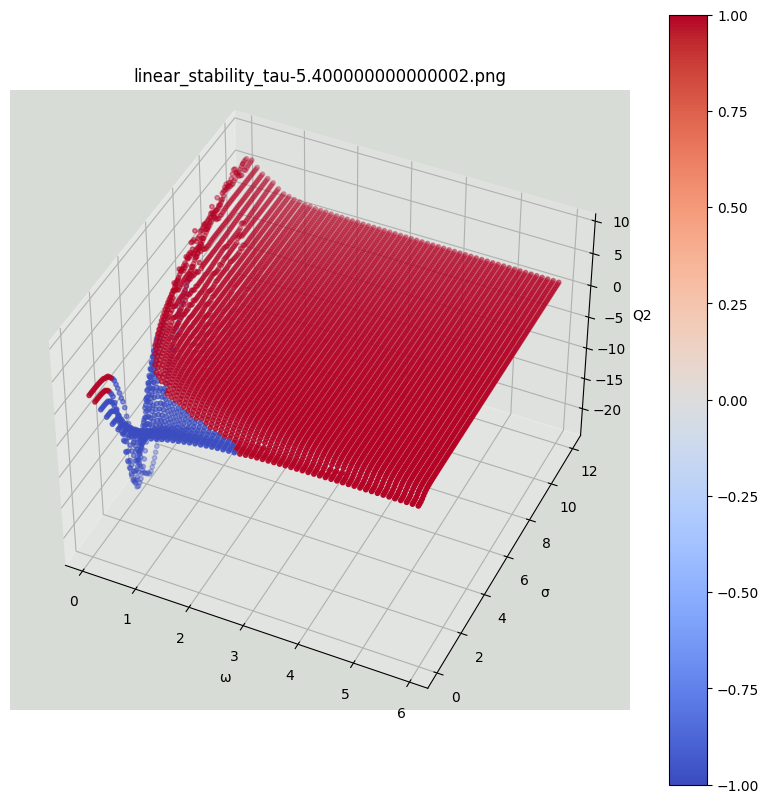

In [68]:
Q = "Q2"

τemp = next(gen)
dat = out.loc[lambda x: x.τ == τemp]

fig_name = f"linear_stability_tau-{τemp}.png"
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

im = ax.scatter(dat.ω, dat.σ, np.sign(dat[Q])*(np.abs(dat[Q])), c=np.sign(dat[Q])
                , s=10, cmap=cm.coolwarm)
_ = ax.set_ylabel('σ')
_ = ax.set_xlabel('ω')
_ = ax.set_zlabel(Q)
_ = ax.set_title(fig_name)

ax.set_facecolor('xkcd:light gray')
ax.view_init(42, -65)

print(dat.loc[lambda x: x[Q] < 0, 'σ'].min())
print(dat.loc[lambda x: x[Q] < 0, 'σ'].max())

τ = τemp
_ = plt.colorbar(im)

plt.savefig(os.path.join(data_save_path, "periodic_orbit_stability_analysis.png"), bbox_inches='tight')

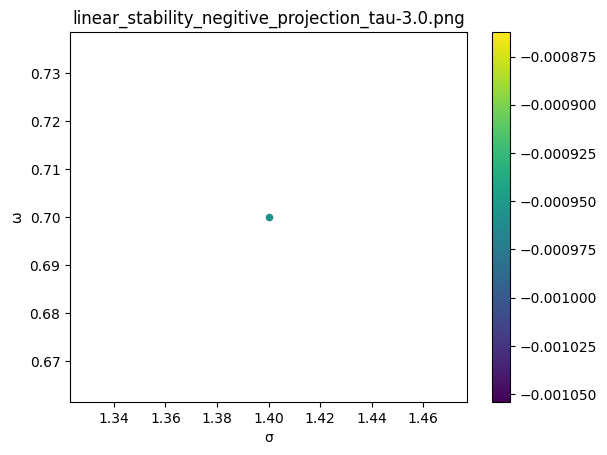

In [750]:
fig_name = f"linear_stability_negitive_projection_tau-{τ}.png"
sdat = dat.loc[lambda x: x.Q2 <0][['ω', 'σ', 'Q2']]
_ = plt.scatter(sdat.σ, sdat.ω, s=20, cmap=cm.viridis, c=sdat.Q2)
_ = plt.xlabel("σ")
_ = plt.ylabel("ω")
_ = plt.title(fig_name)
_ = plt.colorbar()

# plt.facecolor('xkcd:light gray')

# plt.savefig(os.path.join(img_path, fig_name), bbox_inches='tight')